# **Self-Learning VMC guided by RBM**

Author: Lavoisier Wah & Remmy Zen

Here we investigate a NH TFIM using VMC+RBM

### Importing the libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

### Class implementing RBM wavefunction

In [2]:
# For reproducibility purposes
tf.random.set_seed(111)
np.random.seed(111)
random.seed(111)

class VariationalMonteCarloRBM(tf.keras.Model):
    '''
    The VariationalMonteCarlo class combines MLPs with Monte Carlo techniques to model wavefunctions 
    for quantum systems. It samples spin configurations, calculates probabilities, and computes local 
    energies for use in variational calculations.
    '''

    def __init__(self, N, Jz, g_real, g_imag, num_hidden, learning_rate, seed=1234,
                W_array = None, bv_array = None, bh_array = None
                ):
        super(VariationalMonteCarloRBM, self).__init__()
        
        # Parameters
        self.N = N  # Number of spins
        self.Jz = Jz  # Coupling constant in H_I
        self.g_real = g_real  # Real part of g
        self.g_imag = g_imag  # Imaginary part of g
        self.num_hidden = num_hidden
        self.seed     = seed            # Seed of random number generator
        self.l2_regularization = 0.0

        # Define A (even sites) and B (odd sites)
        self.sites_A = tf.range(0, N, 2)  # Even indices
        self.sites_B = tf.range(1, N, 2)  # Odd indices
        
        # Set seed and optimizer
        tf.random.set_seed(self.seed)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate, epsilon=1e-8)

        ## For transfer learning
        ## Weights (W)
        if W_array is None:        
            # self.W_array = np.random.normal(size=(self.N, self.num_hidden), loc=0.0, scale=0.1) 
            self.W_array = np.random.uniform(size=(self.N, self.num_hidden), low=0.0, high=0.01) 
        else:
            self.W_array = W_array
        ## Visible bias (a)
        if bv_array is None:
            self.bv_array = np.zeros((1, self.N))
        else:
            self.bv_array = bv_array
        ## Hidden bias (b)
        if bh_array is None:
            self.bh_array = np.zeros((1, self.num_hidden))
        else:
            self.bh_array = bh_array

        self.W = tf.Variable(tf.convert_to_tensor(value=self.W_array.astype(np.float32)), name="weights", trainable=True)
        self.bv = tf.Variable(tf.convert_to_tensor(value=self.bv_array.astype(np.float32)), name="visible_bias", trainable=True)
        self.bh = tf.Variable(tf.convert_to_tensor(value=self.bh_array.astype(np.float32)), name="hidden_bias", trainable=True)

    #--------------Sampling-----------------
    # Generates 'nsamples' spin configurations based on the RNN's learned probability distribution.
    @tf.function
    def sample(self,nsamples, init_data=None):
        if init_data is None:
            init_data = tf.random.uniform((nsamples, self.N), 0, 2, dtype=tf.dtypes.int32)
            init_data = tf.where(init_data == 0, -1., 1.)

        ## Do gibbs sampling
        logpsi = None
        for i in range(10):
            init_data = self.get_new_visible(init_data)
        return init_data, logpsi

    #@tf.function
    def localenergy(self, samples, logpsi):
        """
        Computes the local energy for the staggered non-Hermitian transverse field Ising model.
        """
        # Initialize the local energy components (real and imaginary parts)
        eloc_real = tf.zeros(shape=[tf.shape(samples)[0]], dtype=tf.float32)
        eloc_imag = tf.zeros(shape=[tf.shape(samples)[0]], dtype=tf.float32)


        # Diagonal contribution: Classical interaction term
        for n in range(self.N):
            eloc_real += -self.Jz * tf.cast((samples[:, n]) * (samples[:, (n + 1)%self.N ]), tf.float32)
        

        # Off-diagonal contributions from staggered transverse fields
        flip_logpsi = tf.zeros(shape=[tf.shape(samples)[0]], dtype=tf.float32)


        # Loop over spins
        for j in range(self.N):
            # Flip the j-th spin
            flip_samples = tf.identity(samples)
            # flip_samples = tf.tensor_scatter_nd_update(flip_samples, [[i, j] for i in range(tf.shape(samples)[0])], 1 - samples[:, j])
            flip_samples = tf.tensor_scatter_nd_update(flip_samples, [[i, j] for i in range(tf.shape(samples)[0])], -1 * samples[:, j])
            # Compute log wavefunction for flipped samples
            flip_logpsi = self.logpsi(flip_samples)

            #real part of the local energy
            eloc_real -= self.g_real * tf.exp(flip_logpsi - logpsi)

            # Contribution from sites in A (even indices)
            if j % 2 == 0:  # Even index (site in A)
                #eloc_real -= self.g_real * tf.exp(flip_logpsi - logpsi)
                eloc_imag -= self.g_imag * tf.exp(flip_logpsi - logpsi)
            else:  # Odd index (site in B)
                #eloc_real -= self.g_real * tf.exp(flip_logpsi - logpsi)
                eloc_imag += self.g_imag * tf.exp(flip_logpsi- logpsi)
                
        return eloc_real, eloc_imag
    # @tf.function
    def logpsi(self, samples):
        theta = tf.matmul(samples, self.W) + self.bh
        
        ## Calculate \sum_{j=1}^H log(cosh(Wx + b))
        sum_ln_thetas = tf.reduce_sum(input_tensor=tf.math.log(tf.cosh(theta)), axis=1, keepdims=True)

        ## calculate ax
        ln_bias = tf.matmul(samples, tf.transpose(a=self.bv))

        return tf.squeeze(0.5 * (sum_ln_thetas + ln_bias))
        

    #----------Magnetization Calculation----------
    def calculate_magnetization(self, samples):
        """
        Compute the magnetization from the VMC samples.
        """
        samples_np = samples.numpy()  # Convert samples tensor to NumPy array
        spin_values = 2 * samples_np - 1  # Map {0, 1} to {-1, 1}
        magnetization = np.mean(spin_values)  # Average over all spins and samples
        return magnetization


    #----------Correlation Function Calculation----------
    def calculate_correlation(self, samples,N):
        """
        Compute the correlation function from the VMC samples.
        """
        samples_np = samples.numpy()  # Convert samples tensor to NumPy array
        spin_values = 2 * samples_np - 1  # Map {0, 1} to {-1, 1}
        
        correlation_function = []
        for r in range(N):  # r ranges from 0 to N-1
            correlations = []
            for i in range(N):
                correlations.append(
                    np.mean(spin_values[:, i] * spin_values[:, (i + r) % N]) #PBC
                )
            correlation_function.append(np.mean(correlations))
        
        return correlation_function

    def get_new_visible(self, v):
        """
            Get new visibile by sampling h from p(h|v) and 
            then sampling v from p(v | h)
        """
        hprob = self.get_hidden_prob_given_visible(v)
        hstate = self.convert_from_prob_to_state(hprob)
        vprob = self.get_visible_prob_given_hidden(hstate)
        vstate = self.convert_from_prob_to_state(vprob)
        return vstate

    def get_hidden_prob_given_visible(self, v):
        """
            Calculate p(h | v)
        """
        return tf.sigmoid(2.0 * (tf.matmul(v, self.W) + self.bh))

    def get_visible_prob_given_hidden(self, h):
        """
            Calculate p(v | h)
        """
        return tf.sigmoid(2.0 * (tf.matmul(h, tf.transpose(a=self.W)) + self.bv))

    
    def convert_from_prob_to_state(self, prob):
        """
            Get state of -1 and 1 from probability 
        """
        v = prob - tf.random.uniform(tf.shape(input=prob), 0, 1)
        return tf.where(tf.greater_equal(v, tf.zeros_like(v)), tf.ones_like(v), -1 * tf.ones_like(v))


    @tf.function
    def derlog(self, x):
        """
        Calculate $D_{W}(x) = D_{W} = (1 / \Psi(x)) * (d \Psi(x) / dW)$ where W can be the weights or the biases.
        """
        sample_size = x.shape[0]

        ## Calculate theta = Wx + b
        theta = tf.matmul(x, self.W) + self.bh

        ## D_a(x) = x
        ## D_b(x) = tanh(Wx + b) 
        D_bv = 0.5 * x 
        D_bh = 0.5 * tf.tanh(theta)

        # D_W(x) = x * tanh(Wx+b)
        D_w = tf.reshape(tf.tanh(theta), (sample_size, 1, self.num_hidden)) * tf.reshape(x, (sample_size, self.N, 1)) 
        D_bv = tf.reshape(D_bv, (sample_size, 1, self.N))
        D_bh = tf.reshape(D_bh, (sample_size, 1, self.num_hidden))

        D_w = tf.reduce_mean(D_w, axis = 0)
        D_bv = tf.reduce_mean(D_bv, axis = 0)
        D_bh = tf.reduce_mean(D_bh, axis = 0)

        derlogs = [D_w, D_bv, D_bh]
        return derlogs

### Define VMC Optimization parameters

In [17]:
# Hamiltonian parameters
N = 10
g_real = 1.6
g_imag = g_real/10
Jz = 1

# RBM-VMC parameters
lr = 0.01     # learning rate of Adam optimizer
nh = 34 #200        # Number of hidden units in the GRU/vanilla RBM cell
ns = 1024      # Number of samples used to approximate the energy at each step
steps = 1000  # Training iterations
seed = 111    # Seed of RNG (for the purpose of reproducibility)
alpha =0.1  #scaling parameter to tune the loss if needed

### Run VMC + RBM and training

In [18]:
print("Running VMC for Jz", Jz,", g =", g_real+ 1j*g_imag)
#tf.random.set_seed(seed)
vmc = VariationalMonteCarloRBM(N,Jz, g_real, g_imag,nh,lr,seed)
RBMEnergy = []
varRBMEnergy = []
e_rel=[]

#file = open('VMC_RBM_energy'+str(N)+'_'+str(g_real)+'.txt', "w+")

for it in range(1, steps + 1):
    if it == 1:
        samples, _ = vmc.sample(ns)
    ## Otherwise reuse previous samples
    else:
        samples, _ = vmc.sample(ns, samples)

    # Evaluate the loss function in Automatic Differentiation mode
    with tf.GradientTape() as tape:
        logpsi = vmc.logpsi(samples)
        with tape.stop_recording():
            eloc_real, eloc_imag = vmc.localenergy(samples, logpsi)  # Now returns real and imag parts
            Eo_real = tf.reduce_mean(eloc_real)
            Eo_imag = tf.reduce_mean(eloc_imag)

        # Loss function for real and imaginary parts
        loss_real = tf.reduce_mean(2.0 * tf.multiply(logpsi, tf.stop_gradient(eloc_real)) 
                                   - 2.0 * tf.stop_gradient(Eo_real) * logpsi)
        loss_imag = tf.reduce_mean(2.0 * tf.multiply(logpsi, tf.stop_gradient(eloc_imag)) 
                                   - 2.0 * tf.stop_gradient(Eo_imag) * logpsi)

        # Total loss
        loss = loss_real + alpha*loss_imag
      
    # Compute the gradients
    gradients = tape.gradient(loss, vmc.trainable_variables)

    # Update the parameters
    vmc.optimizer.apply_gradients(zip(gradients, vmc.trainable_variables))

    # Monitor energies
    energies_real = eloc_real.numpy()
    energies_imag = eloc_imag.numpy()
    avg_E_real = np.mean(energies_real)
    avg_E_imag = np.mean(energies_imag)
    avg_E = avg_E_real +1j*avg_E_imag
    var_E_real = np.var(energies_real)
    var_E_imag = np.var(energies_imag)

    # Append to tracking lists
    RBMEnergy.append(avg_E_real +1j*avg_E_imag)
    #RBMEnergy.append(-np.abs(avg_E_real + 1j * avg_E_imag))
    varRBMEnergy.append(var_E_real + 1j * var_E_imag)
    


    # Print progress
    if it % 100 == 0 or it == 1:
        print(f"Iteration {it}:")
        print(f"  Avg Energy: {avg_E_real} + {avg_E_imag}j")
        print(f"  Variance: {var_E_real} + {var_E_imag}j")



Running VMC for Jz 1 , g = (1.6+0.16j)
tf.Tensor(-0.009459772, shape=(), dtype=float32)
Iteration 1:
  Avg Energy: -15.945602416992188 + 3.417510015424341e-05j
  Variance: 10.030034065246582 + 1.7596144061826635e-06j
tf.Tensor(-0.07551411, shape=(), dtype=float32)
tf.Tensor(-0.22442485, shape=(), dtype=float32)
tf.Tensor(-0.3703168, shape=(), dtype=float32)
tf.Tensor(-0.46734986, shape=(), dtype=float32)
tf.Tensor(-0.43355024, shape=(), dtype=float32)
tf.Tensor(1.4581316, shape=(), dtype=float32)
tf.Tensor(2.0064228, shape=(), dtype=float32)
tf.Tensor(1.2452849, shape=(), dtype=float32)
tf.Tensor(0.58147323, shape=(), dtype=float32)
tf.Tensor(-0.19269662, shape=(), dtype=float32)
tf.Tensor(-0.44749895, shape=(), dtype=float32)
tf.Tensor(-0.43003583, shape=(), dtype=float32)
tf.Tensor(-0.5738765, shape=(), dtype=float32)
tf.Tensor(-0.51773655, shape=(), dtype=float32)
tf.Tensor(-0.43171284, shape=(), dtype=float32)
tf.Tensor(-0.27420828, shape=(), dtype=float32)
tf.Tensor(-0.010732494, 

In [11]:
#Computing the ground state energy by taking the last RBM energy
ed=-17.606760956539285-1.434936765735452e-16j #1.6
#ed= -13.460488686381876+7.761730733344498e-16j #small im 1.1
#ed=-12.183029723679834-6.234725255422726e-16j #0.9
#ed =-10.630309447844699-9.474196816028099e-17j #0.5
#ed= -21.270457296476174+9.758938767028602e-18j #2.0

print("RBM variational energy at the end of training = ", RBMEnergy[-1], "+-", np.sqrt(varRBMEnergy[-1]/ns) )
print("Exact ground state energy = ", ed)

RBM variational energy at the end of training =  (-17.60724639892578+0.0012456601252779365j) +- (0.0023963159682120934+0.0021377313605451566j)
Exact ground state energy =  (-17.606760956539286-1.434936765735452e-16j)


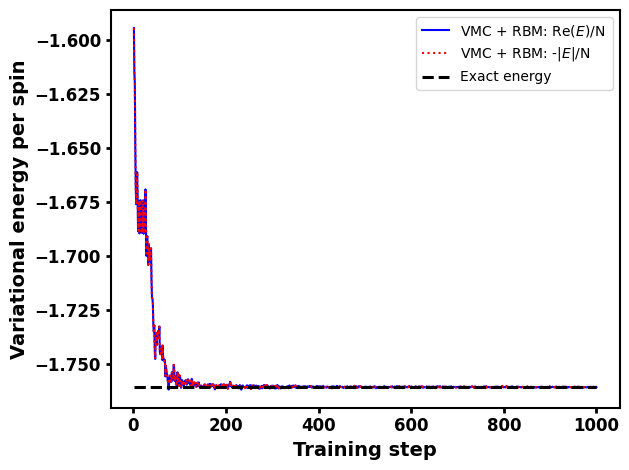

In [19]:
#Plot of the Ground state energy
plt.plot(np.arange(1, len(RBMEnergy)+1), np.real(RBMEnergy)/N, "b-", label=r"VMC + RBM: Re($E$)/N ")
plt.plot(np.arange(1, len(RBMEnergy)+1), -np.abs(RBMEnergy)/N, "r:", label=r"VMC + RBM: -|$E$|/N")
plt.plot(np.arange(1, len(RBMEnergy)+1), [np.real(ed)/N]*len(RBMEnergy), "k--", lw=2.2, label="Exact energy")
plt.xlabel(r'Training step',fontsize=14, fontweight='bold')
plt.ylabel('Variational energy per spin',fontsize=14, fontweight='bold')
# Customize tick labels
plt.xticks(fontsize=12, fontweight='bold')  # Bold and larger tick labels for x-axis
plt.yticks(fontsize=12, fontweight='bold')  # Bold and larger tick labels for y-axis
# Customize axis spines (thickness)
ax = plt.gca()  # Get the current axes
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
# Customize tick line width
ax.tick_params(width=2.0)
# Automatically adjust layout to avoid clipping
plt.tight_layout()
plt.legend()
#plt.savefig('RBM_energy.pdf', dpi=300)
plt.show()


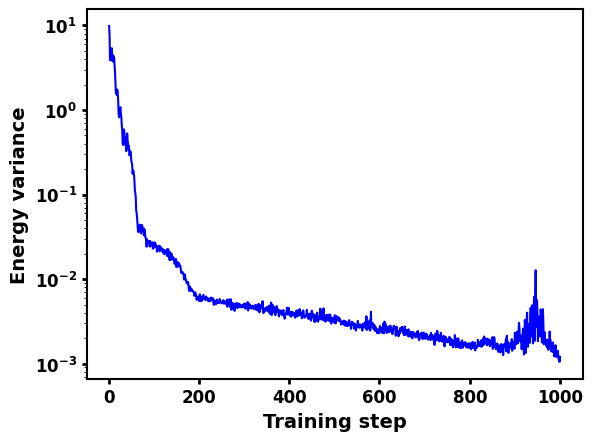

In [15]:
#Plot of the Variance
plt.semilogy(np.arange(1, len(RBMEnergy)+1), np.real(varRBMEnergy), "b-", label="Energy variance of the RBM")
plt.xlabel(r'Training step',fontsize=14, fontweight='bold')
plt.ylabel('Energy variance',fontsize=14, fontweight='bold')
# Customize tick labels
plt.xticks(fontsize=12, fontweight='bold')  # Bold and larger tick labels for x-axis
plt.yticks(fontsize=12, fontweight='bold')  # Bold and larger tick labels for y-axis
# Customize axis spines (thickness)
ax = plt.gca()  # Get the current axes
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
# Customize tick line width
ax.tick_params(width=2.0)
#plt.legend()
#plt.savefig('RBM_variance.pdf', dpi=300)
plt.show()

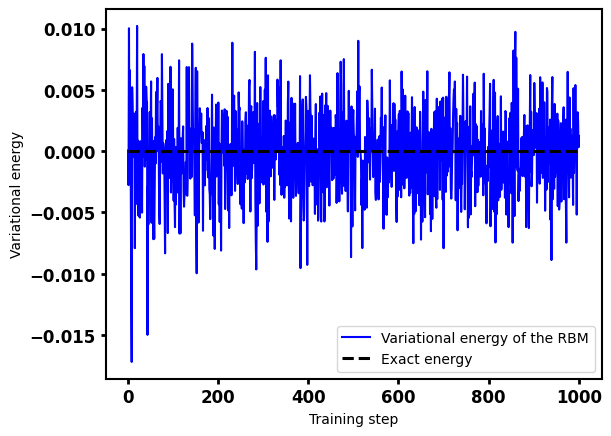

In [16]:
#Imaginary part of the energy
plt.plot(np.arange(1, len(RBMEnergy)+1), np.imag(RBMEnergy), "b-", label="Variational energy of the RBM")
plt.plot(np.arange(1, len(RBMEnergy)+1), [np.imag(ed)]*len(RBMEnergy), "k--", lw=2.2, label="Exact energy")
plt.xlabel(r'Training step')
plt.ylabel('Variational energy')
# Customize tick labels
plt.xticks(fontsize=12, fontweight='bold')  # Bold and larger tick labels for x-axis
plt.yticks(fontsize=12, fontweight='bold')  # Bold and larger tick labels for y-axis
# Customize axis spines (thickness)
ax = plt.gca()  # Get the current axes
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
# Customize tick line width
ax.tick_params(width=2.0)
plt.legend()
#plt.savefig('RBM_Im_energy.pdf', dpi=300)
plt.show()